# Plot Sequence Logo
## Demos

In [1]:
import numpy as np
import pandas as pd
import h5py

In [ ]:
seq_path = './Seqs/attention_h2O_101_23.csv'
config = seq_path.split('/')[-1].split('.')[0]

In [ ]:
attention = pd.read_csv('./Seqs/attention_h2O_101_23.csv',index_col=0,header=0)
columns_name = [ele[0] for ele in list(attention.columns)]
h2O = attention.loc['h2O'].values

In [14]:
def add_zero(height,seq):
    length = len(seq)
    out = np.zeros((length,4))
    for i in range(length):
        if seq[i] == 'A':
            out[i,0] = height[i]
        elif seq[i] == 'C':
            out[i,1] = height[i]
        elif seq[i] == 'G':
            out[i,2] = height[i]
        else:
            out[i,3] = height[i]
    return out

In [ ]:
test = add_zero(h2O,columns_name)

In [2]:
from plotseqlogo import seqlogo, seqlogo_fig

Using TensorFlow backend.
C:\Users\acer\anaconda3\envs\seqlogo\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\acer\anaconda3\envs\seqlogo\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\acer\anaconda3\envs\seqlogo\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\acer\anaconda3\envs\seqlogo\lib\sit

OSError: [WinError 126] 找不到指定的模块。

In [ ]:
fig = seqlogo_fig(test, vocab="RNA", figsize=(30, 2), ncol=1, plot_name='h2O')
#fig.savefig('./Figs/'+config  + '.png')

In [ ]:
seqlogo_fig(test, vocab="DNA", figsize=(30, 2), ncol=1, plot_name='hm7G_v1_neg')

In [ ]:
one_hot = pd.read_csv('./Seqs/ig_onehot.csv',index_col=0).to_numpy()
print(one_hot.shape)
seqlogo_fig(one_hot, vocab="DNA", figsize=(30, 2), ncol=1, plot_name='hm7G_v1_positive')

In [ ]:
(51-7) //2 + 1

In [ ]:
def cal_out_features(in_features,stride,kernel_size,padding):
    return (in_features-kernel_size+2*padding) // stride + 1

In [ ]:
cal_out_features(12,2,2,1)

In [ ]:
seq_path = './Seqs/ig_onehot_cnn_h2O_101_23.csv'
config = seq_path.split('/')[-1].split('.')[0]
one_hot = pd.read_csv(seq_path,index_col=0).to_numpy()
print(one_hot.shape)
fig = seqlogo_fig(one_hot, vocab="DNA", figsize=(30, 2), ncol=1, plot_name='h2O_positive')
fig.savefig('./Figs/'+config  + '.png')

# Experiment

In [6]:
%matplotlib inline 
RMs = ['hAm','hCm','hGm','hUm','hm1A','hm5C','hm5U','hm6A','hm6Am','hm7G','hPsi','Atol']
RM = 'hm6Am'
RM_index = RMs.index(RM)

In [8]:
attention_weights = h5py.File('./Seqs/att_hm6Am_51.h5','r').get(RM)
attention_weights = attention_weights[:,RM_index,:]
attention_weights.shape

(5, 51)

In [9]:
attributions = h5py.File('./Seqs/ig_hm6Am_51.h5','r').get(RM)

In [11]:
num_samples, length = attention_weights.shape[0], attention_weights.shape[1]
results = np.zeros((num_samples,length,4))

In [12]:
with open('./Seqs/high_hm6Am_test.txt','r') as f_obj:
    seqs = f_obj.read()
seqs = seqs.split('\n')

In [15]:
for i in range(num_samples):
    results[i,:] = add_zero(height=attention_weights[i,:],seq=seqs[i])

In [2]:
#######################################################################################
### Code adoped from  https://github.com/c/concise (c) 2016, Žiga Avsec Gagneur lab ### #######################################################################################

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math

from concise.preprocessing.sequence import DNA, RNA, AMINO_ACIDS
from concise.utils.letters import all_letters
from collections import OrderedDict

from matplotlib import pyplot
from matplotlib.patches import PathPatch
from matplotlib.path import Path

from descartes.patch import Polygon, PolygonPath, PolygonPatch
from shapely.wkt import loads as load_wkt

from shapely import affinity
import re




def standardize_polygons_str(data_str):
    """Given a POLYGON string, standardize the coordinates to a 1x1 grid.
    Input : data_str (taken from above)
    Output: tuple of polygon objects
    """
    # find all of the polygons in the letter (for instance an A
    # needs to be constructed from 2 polygons)
    path_strs = re.findall("\(\(([^\)]+?)\)\)", data_str.strip())

    # convert the data into a numpy array
    polygons_data = []
    for path_str in path_strs:
        data = np.array([
            tuple(map(float, x.split())) for x in path_str.strip().split(",")])
        polygons_data.append(data)

    # standardize the coordinates
    min_coords = np.vstack(data.min(0) for data in polygons_data).min(0)
    max_coords = np.vstack(data.max(0) for data in polygons_data).max(0)
    for data in polygons_data:
        data[:, ] -= min_coords
        data[:, ] /= (max_coords - min_coords)

    polygons = []
    for data in polygons_data:
        polygons.append(load_wkt(
            "POLYGON((%s))" % ",".join(" ".join(map(str, x)) for x in data)))

    return tuple(polygons)


# ----------------------
letter_polygons = {k: standardize_polygons_str(v) for k, v in all_letters.items()}

VOCABS = {"DNA": OrderedDict([("A", "red"),
                          ("C", "blue"),
                          ("G", "orange"),
                          ("T", "green")]),
      "RNA": OrderedDict([("A", "red"),
                          ("C", "blue"),
                          ("G", "orange"),
                          ("U", "green")]),
      "AA": OrderedDict([('A', '#CCFF00'),
                         ('B', "orange"),
                         ('C', '#FFFF00'),
                         ('D', '#FF0000'),
                         ('E', '#FF0066'),
                         ('F', '#00FF66'),
                         ('G', '#FF9900'),
                         ('H', '#0066FF'),
                         ('I', '#66FF00'),
                         ('K', '#6600FF'),
                         ('L', '#33FF00'),
                         ('M', '#00FF00'),
                         ('N', '#CC00FF'),
                         ('P', '#FFCC00'),
                         ('Q', '#FF00CC'),
                         ('R', '#0000FF'),
                         ('S', '#FF3300'),
                         ('T', '#FF6600'),
                         ('V', '#99FF00'),
                         ('W', '#00CCFF'),
                         ('Y', '#00FFCC'),
                         ('Z', 'blue')]),
      "RNAStruct": OrderedDict([("P", "red"),
                                ("H", "green"),
                                ("I", "blue"),
                                ("M", "orange"),
                                ("E", "violet")]),
      }
# make sure things are in order
VOCABS["AA"] = OrderedDict((k, VOCABS["AA"][k]) for k in AMINO_ACIDS)
VOCABS["DNA"] = OrderedDict((k, VOCABS["DNA"][k]) for k in DNA)
VOCABS["RNA"] = OrderedDict((k, VOCABS["RNA"][k]) for k in RNA)


def add_letter_to_axis(ax, let, col, x, y, height):
    """Add 'let' with position x,y and height height to matplotlib axis 'ax'.
    """
    if len(let) == 2:
        colors = [col, "white"]
    elif len(let) == 1:
        colors = [col]
    else:
        raise ValueError("3 or more Polygons are not supported")

    for polygon, color in zip(let, colors):
        new_polygon = affinity.scale(
            polygon, yfact=height, origin=(0, 0, 0))
        new_polygon = affinity.translate(
            new_polygon, xoff=x, yoff=y)
        patch = PolygonPatch(new_polygon, edgecolor=color, facecolor=color)
        #patch = PolygonPatch(new_polygon, edgecolor=None, facecolor=color)
        ax.add_patch(patch)
    return


def seqlogo(letter_heights, vocab="DNA", ax=None):
    """Make a logo plot
    # Arguments
        letter_heights: "motif length" x "vocabulary size" numpy array
    Can also contain negative values.
        vocab: str, Vocabulary name. Can be: DNA, RNA, AA, RNAStruct.
        ax: matplotlib axis
    """
    ax = ax or plt.gca()

    assert letter_heights.shape[1] == len(VOCABS[vocab])
    x_range = [1, letter_heights.shape[0]]
    pos_heights = np.copy(letter_heights)
    pos_heights[letter_heights < 0] = 0
    neg_heights = np.copy(letter_heights)
    neg_heights[letter_heights > 0] = 0

    for x_pos, heights in enumerate(letter_heights):
        letters_and_heights = sorted(zip(heights, list(VOCABS[vocab].keys())))
        y_pos_pos = 0.0
        y_neg_pos = 0.0
        for height, letter in letters_and_heights:
            color = VOCABS[vocab][letter]
            polygons = letter_polygons[letter]
            if height > 0:
                add_letter_to_axis(ax, polygons, color, 0.5 + x_pos, y_pos_pos, height)
                y_pos_pos += height
            else:
                add_letter_to_axis(ax, polygons, color, 0.5 + x_pos, y_neg_pos, height)
                y_neg_pos += height

    # if add_hline:
    #     ax.axhline(color="black", linewidth=1)
    ax.set_xlim(x_range[0] - 1, x_range[1] + 1)
    ax.grid(False)
    #ax.set_xticks(list(range(*x_range)) + [x_range[-1]])
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.yaxis.set_tick_params(labelsize=8)
    ax.set_aspect(aspect='auto', adjustable='box')
    ax.autoscale_view()
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     ax.spines['bottom'].set_visible(False)
#     ax.spines['left'].set_visible(False)


def seqlogo_fig(letter_heights, vocab="DNA", figsize=(10, 2), ncol=1, plot_name=None):
    """
    # Arguments
        plot_name: Title of the plot. Can be a list of names
    """
    fig = plt.figure(figsize=figsize)

    if len(letter_heights.shape) == 3:
        #
        n_plots = letter_heights.shape[2]
        nrow = math.ceil(n_plots / ncol)
        if isinstance(plot_name, list):
            assert len(plot_name) == n_plots
    else:
        n_plots = 1
        nrow = 1
        ncol = 1

    for i in range(n_plots):
        if len(letter_heights.shape) == 3:
            w_cur = letter_heights[:, :, i]
        else:
            w_cur = letter_heights
        ax = plt.subplot(nrow, ncol, i + 1)
        plt.tight_layout(h_pad=0.01)

        # plot the motif
        seqlogo(w_cur, vocab, ax)

        # add the title
        if plot_name is not None:
            if n_plots > 0:
                if isinstance(plot_name, list):
                    pln = plot_name[i]
                else:
                    pln = plot_name + " {0}".format(i+1)
            else:
                pln = plot_name
#            ax.set_title(pln)
    return fig



import math
def seqlogo_fig_cross(letter_heights, vocab="DNA", figsize=(10, 2), ncol=1, plot_name=None, crosssite=False, cross_positions=None,axisplot=True):
    """
    # Arguments
        plot_name: Title of the plot. Can be a list of names
    """

    params = {'axes.labelsize': 10, # fontsize for x and y labels (was 10)
              'axes.titlesize': 10,
              'font.size': 10,
              'legend.fontsize': 10, # was 10
              'xtick.labelsize': 8,
              'ytick.labelsize': 8,
              'text.usetex': False,
              'font.family': 'serif',
          'pdf.fonttype' : 42
    }

    import matplotlib
    from matplotlib.ticker import FormatStrFormatter
    matplotlib.rcParams.update(params)

    fig = plt.figure(figsize=figsize)

    if len(letter_heights.shape) == 3:
        #
        n_plots = letter_heights.shape[2]
        nrow = math.ceil(n_plots / ncol)
        if isinstance(plot_name, list):
            assert len(plot_name) == n_plots
    else:
        n_plots = 1
        nrow = 1
        ncol = 1

    for i in range(n_plots):
        if len(letter_heights.shape) == 3:
            w_cur = letter_heights[:, :, i]
        else:
            w_cur = letter_heights
        ax = plt.subplot(nrow, ncol, i + 1)
        plt.tight_layout(h_pad=0.01)
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        if not axisplot:
            plt.box(False)
            plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
            plt.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
        # plot the motif
        seqlogo(w_cur, vocab, ax)
        if crosssite:
            if len(letter_heights.shape) == 3:
                start = cross_positions[i][0]
                end = cross_positions[i][1]
            else:
                start = cross_positions[0]
                end = cross_positions[1]
            ax.axvline(x=start,color="purple", linewidth=1)
            ax.axvline(x=end,color="purple", linewidth=1)
        # add the title
        if plot_name is not None:
            if n_plots > 0:
                if isinstance(plot_name, list):
                    pln = plot_name[i]
                else:
                    pln = plot_name + " {0}".format(i)
            else:
                pln = plot_name
#            ax.set_title(pln)
    return fig

Using TensorFlow backend.
C:\Users\acer\anaconda3\envs\py3.6\lib\site-packages\tensorflow\python\framework\dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\acer\anaconda3\envs\py3.6\lib\site-packages\tensorflow\python\framework\dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\acer\anaconda3\envs\py3.6\lib\site-packages\tensorflow\python\framework\dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\acer\anaconda3\envs\py3.6\lib\site-packag

# Viualized by attention weights (Top 10% hm6Am) Test set

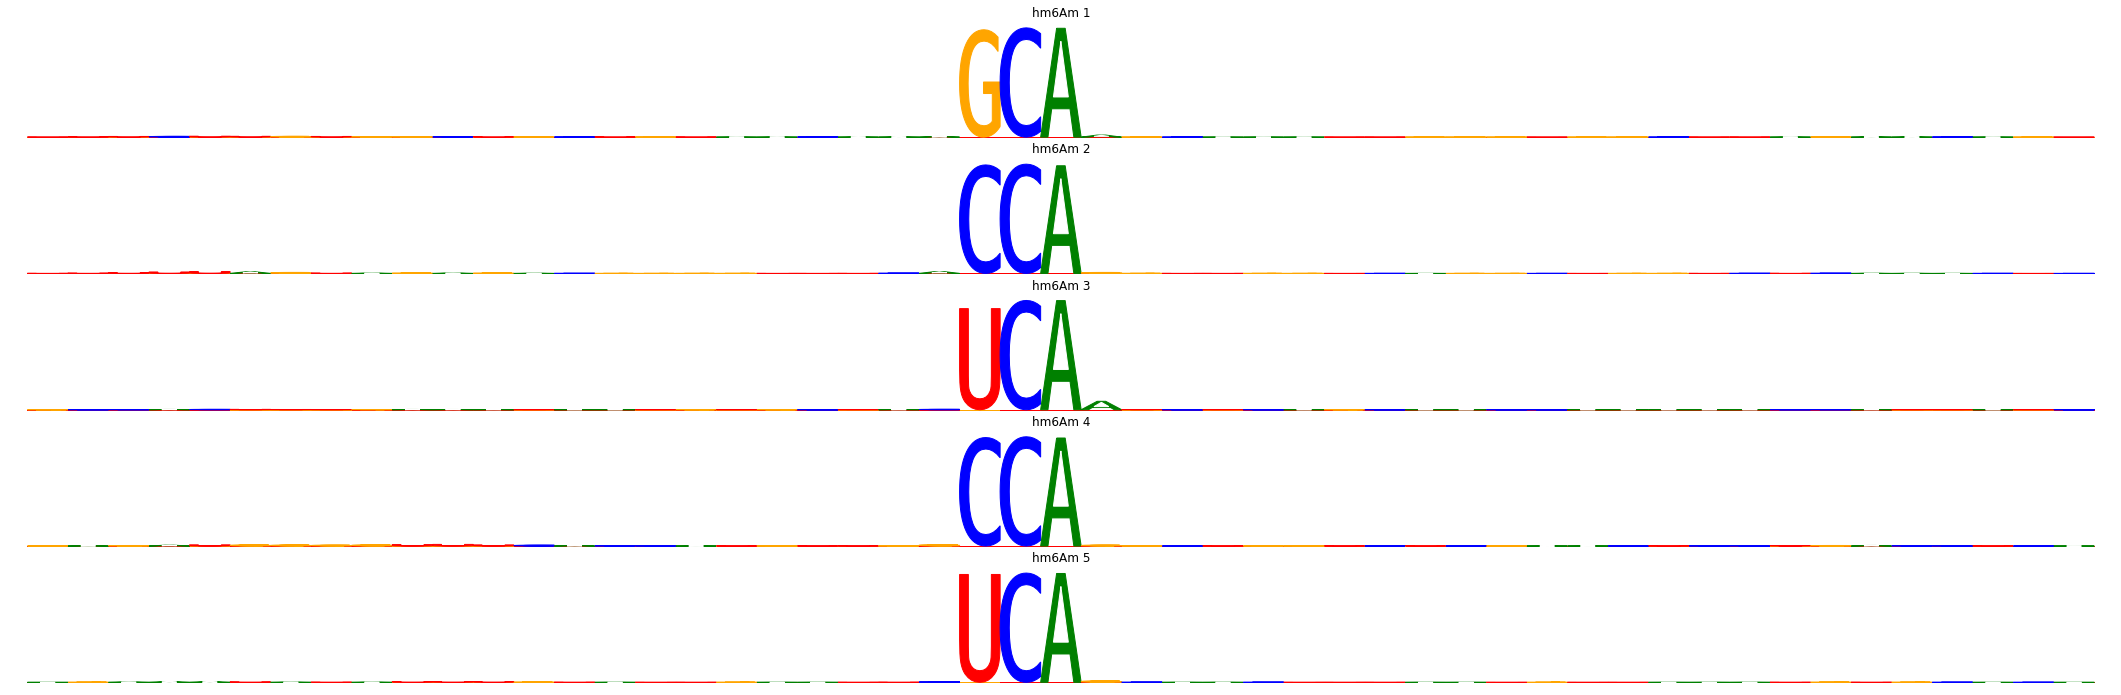

In [16]:
fig = seqlogo_fig(np.transpose(results,axes=(1,2,0)), vocab="RNA", figsize=(30, 10), ncol=1, plot_name=RM)
# fig.savefig('./Figs/test_att.png')

# Visualized by integrated gradients (Top 10% hm6Am) Test set

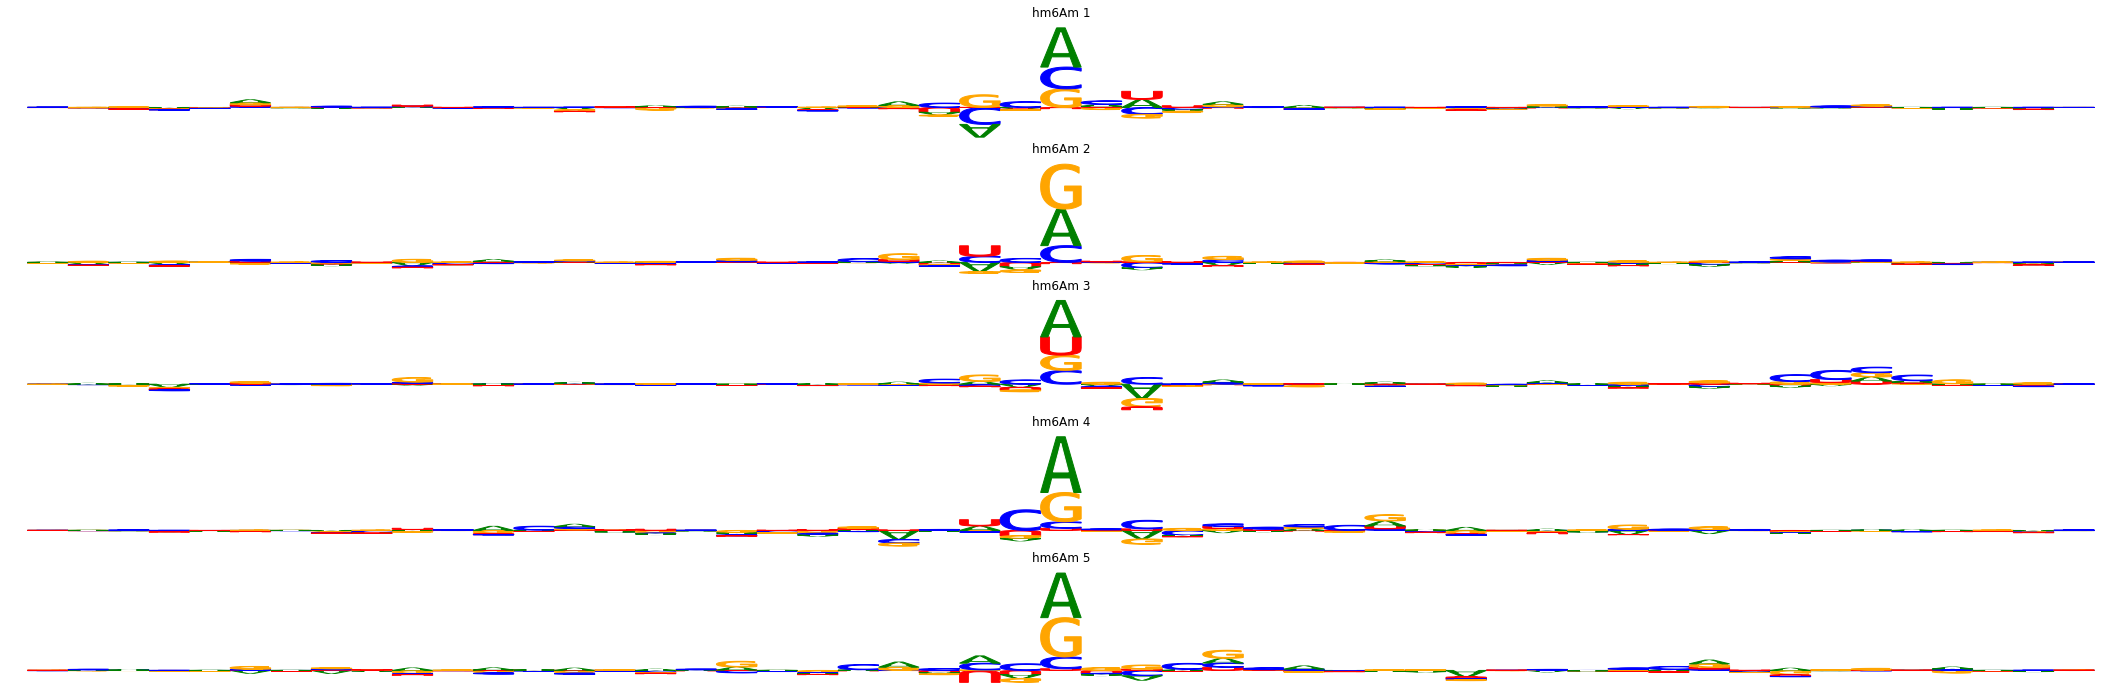

In [18]:
fig = seqlogo_fig(np.transpose(attributions,axes=(2,1,0)), vocab="RNA", figsize=(30, 10), ncol=1, plot_name=RM)
# fig.savefig('./Figs/test_att.png')

# Consensus Motif (Based on PWM)

In [4]:
def trim(data):
    '''
    Input data: (length,4)
    '''
    length, _ = data.shape
    outs = [] 
    for i in range(length):
        if (data[i,0] != data[i,1]) or (data[i,0] != data[i,2]) or (data[i,0] != data[i,3]):
            outs.append(data[i,:].tolist())
    result = np.vstack(outs)
    return result

In [25]:
np.array([1,2,3]).tolist()

[1, 2, 3]

In [5]:
RMs = ['hAm','hCm','hGm','hUm','hm1A','hm5C','hm5U','hm6A','hm6Am','hm7G','hPsi','Atol']

In [6]:
cm = h5py.File('./Seqs/cm_valid_51_6_top75','r')
for RM in RMs:
    motifs = cm[RM][:]
    cluster = motifs.shape[0]
    print('%s %d clusters'%(RM,cluster))

hAm 9 clusters
hCm 9 clusters
hGm 8 clusters
hUm 10 clusters
hm1A 8 clusters
hm5C 8 clusters
hm5U 11 clusters
hm6A 11 clusters
hm6Am 11 clusters
hm7G 9 clusters
hPsi 9 clusters
Atol 6 clusters


In [6]:
cm = h5py.File('./Seqs/new/cm_train_51_wid8_top2_eps0.35','r')
for RM in RMs:
    motifs = cm[RM][:]
    cluster = motifs.shape[0]
    print('%s %d clusters'%(RM,cluster))

hAm 22 clusters
hCm 12 clusters
hGm 13 clusters
hUm 21 clusters
hm1A 32 clusters
hm5C 5 clusters
hm5U 23 clusters
hm6A 13 clusters
hm6Am 17 clusters
hm7G 11 clusters
hPsi 13 clusters
Atol 9 clusters


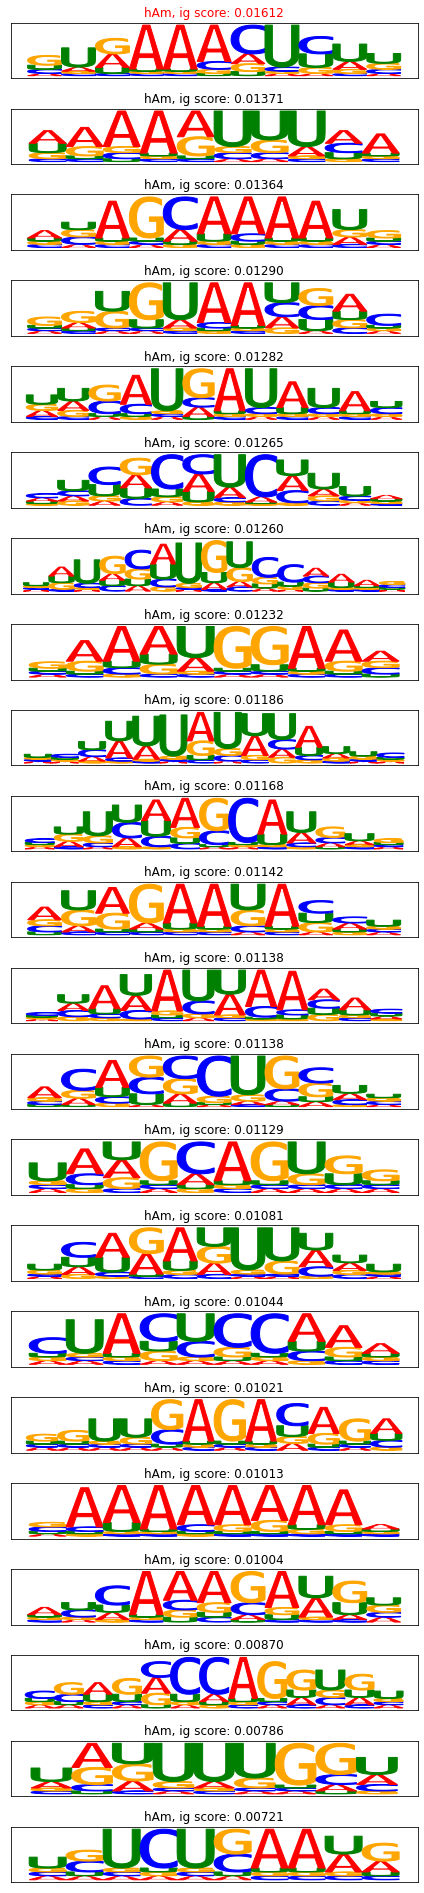

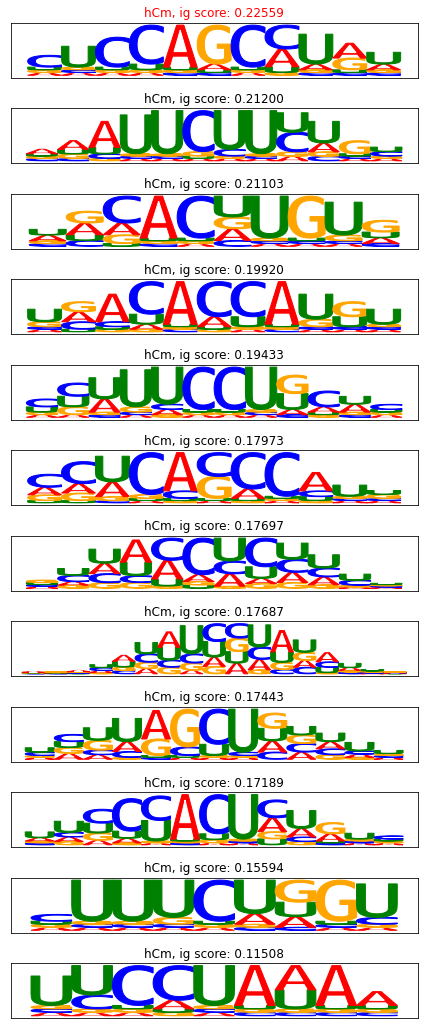

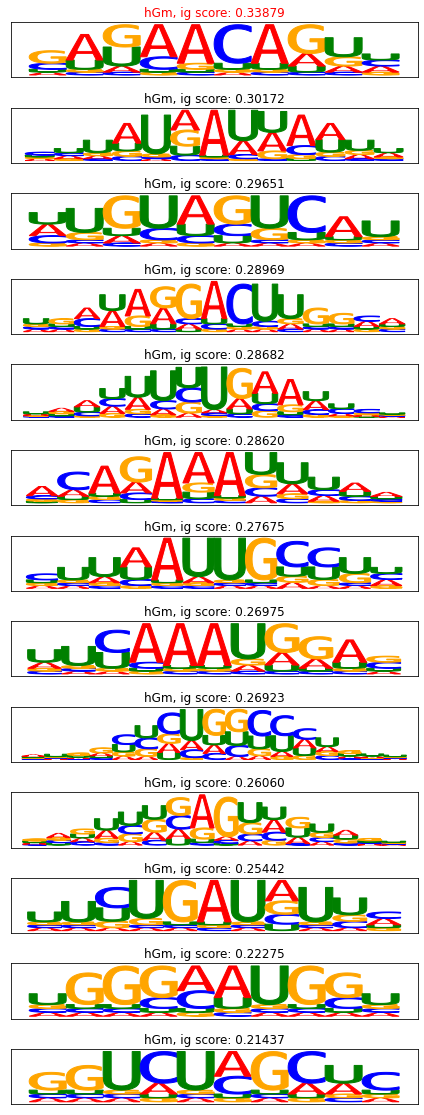

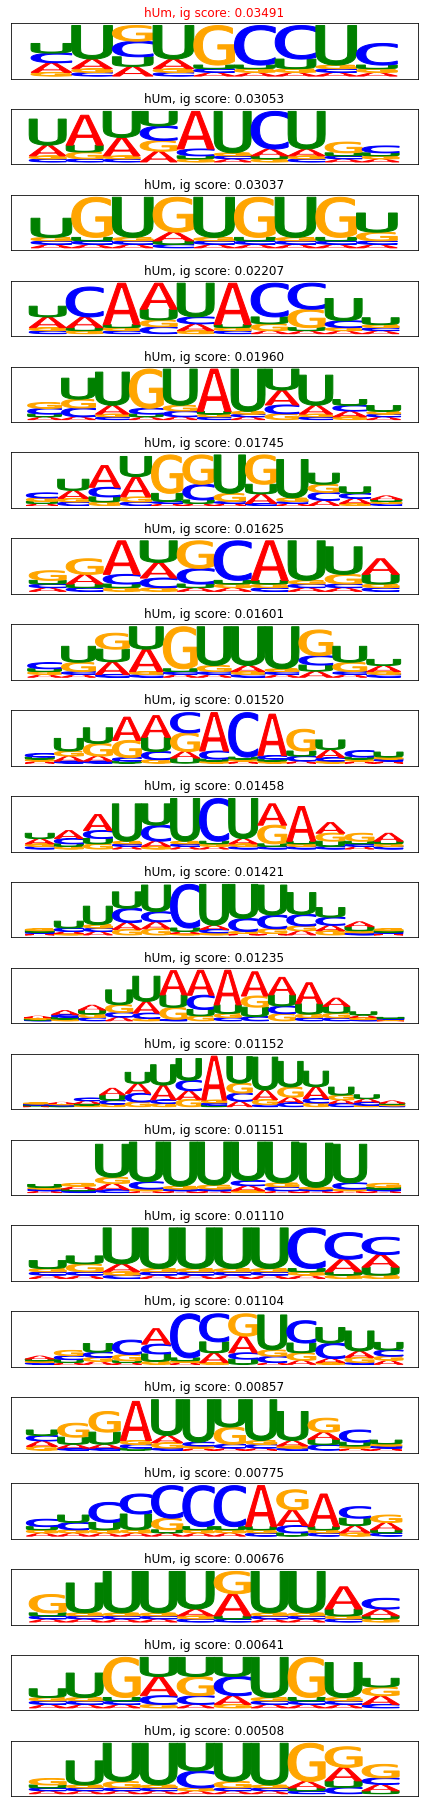

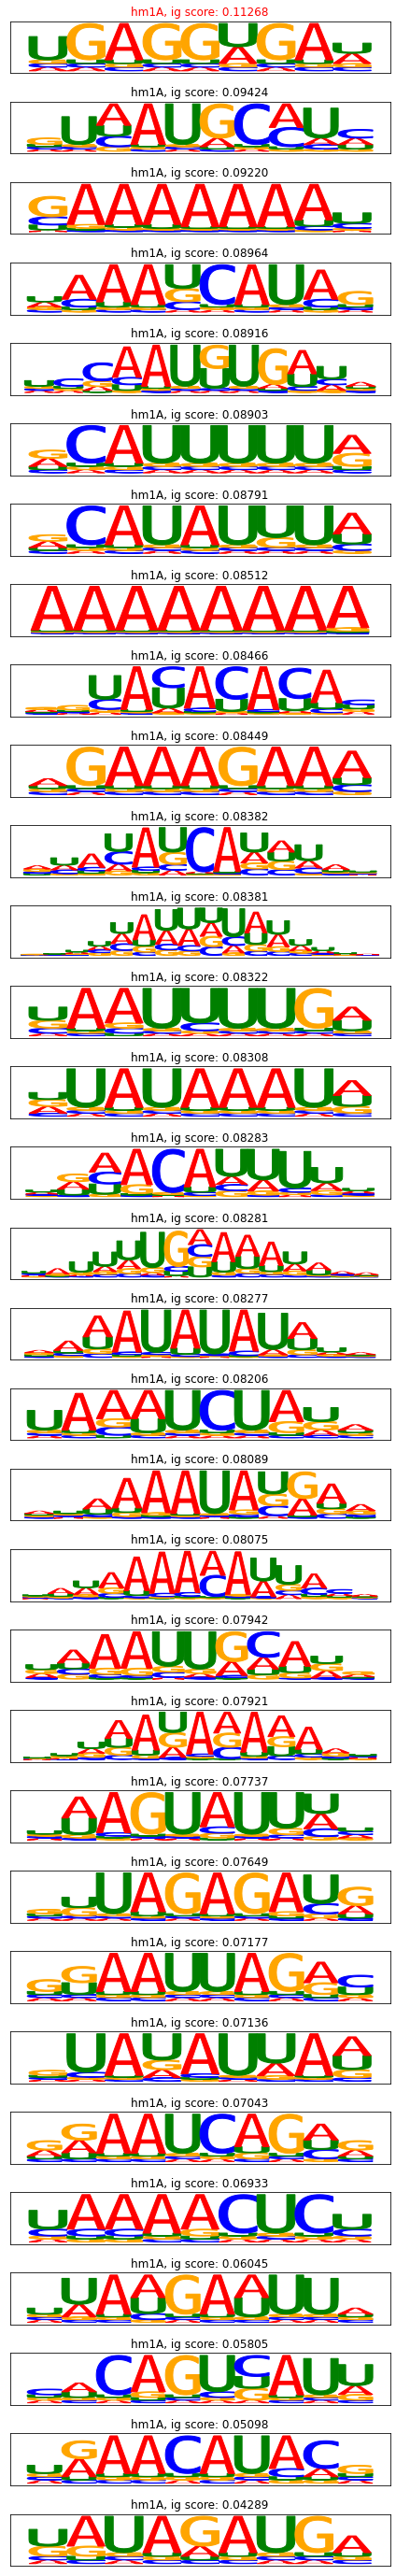

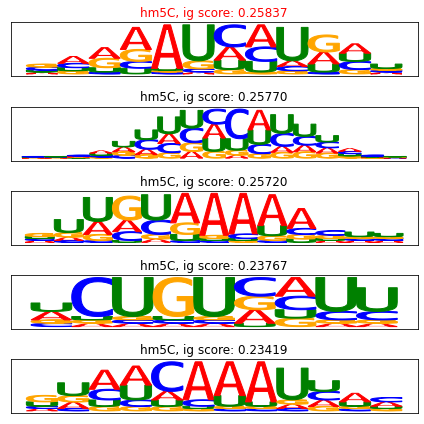

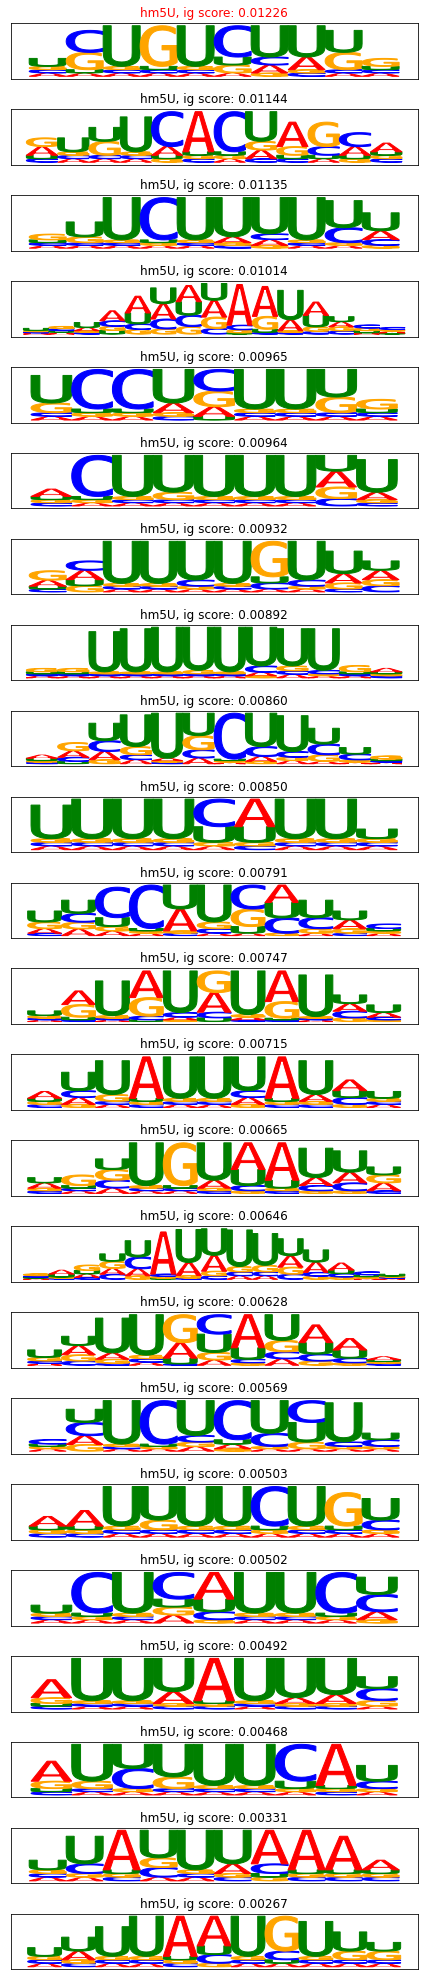

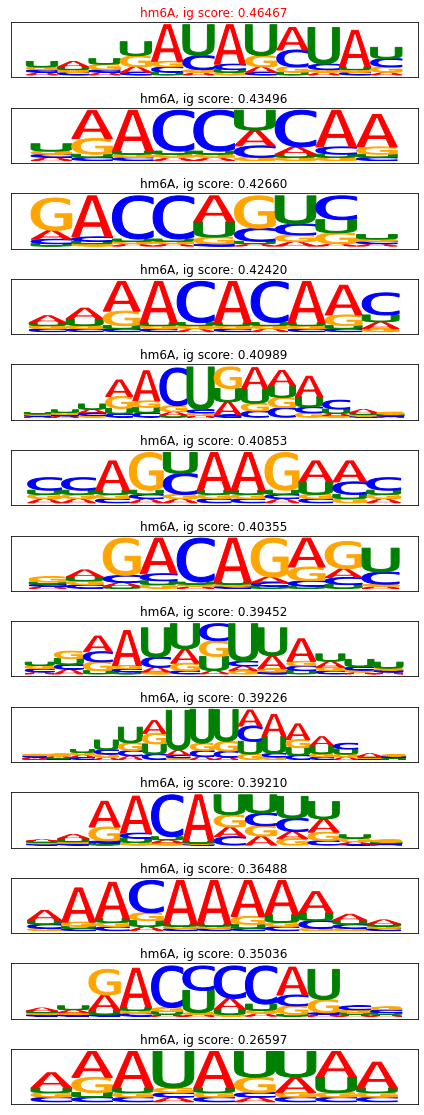

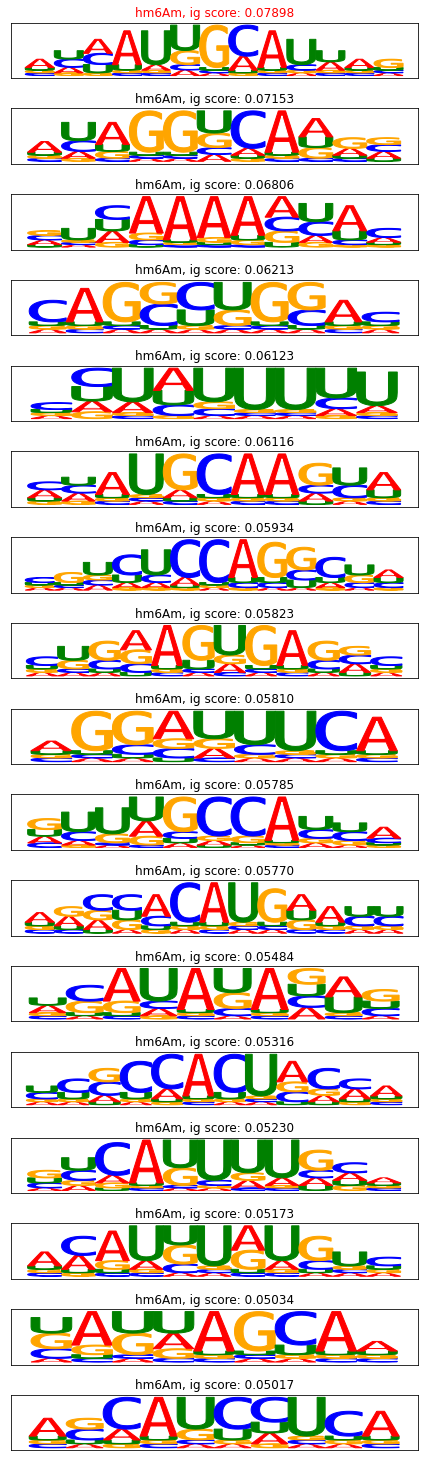

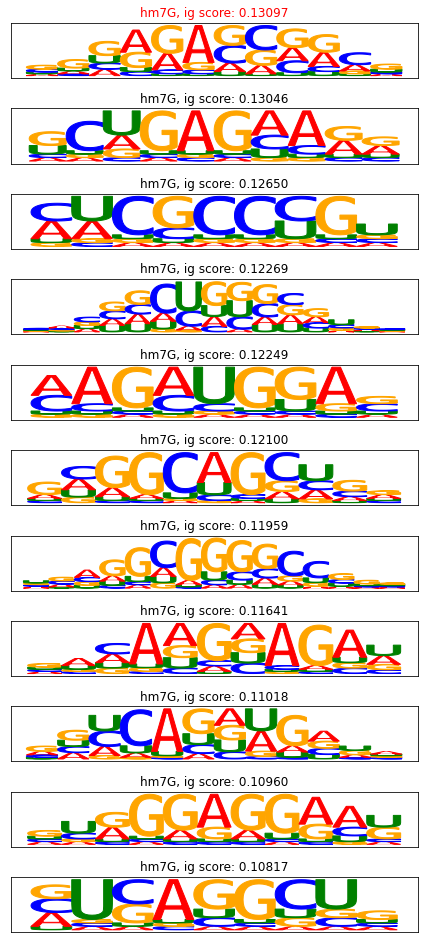

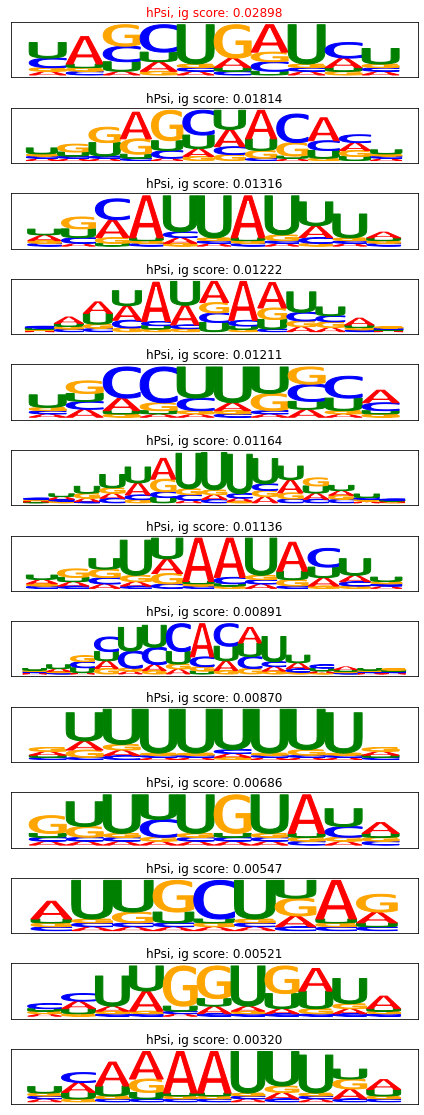

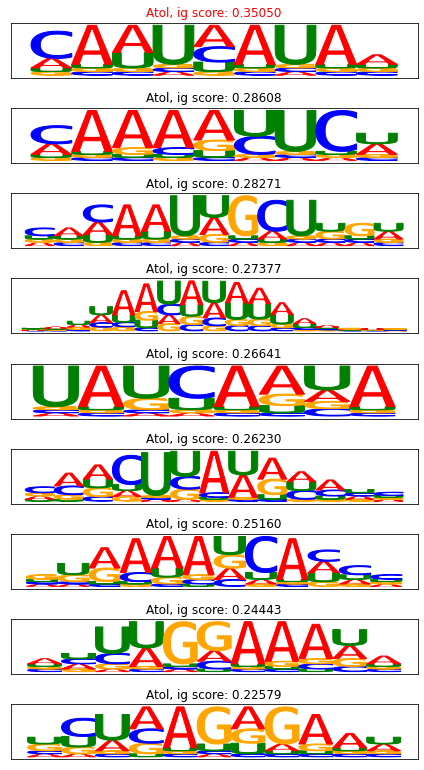

In [9]:
for i in range(len(RMs)):
    RM = RMs[i]
    heights = cm[RM][:]
    n_cluster = heights.shape[0]
    score = cm['%s_ig'%(RM)][:]
    score_max = np.max(score)
    ig, axes = plt.subplots(n_cluster,1,figsize=(6,1.2*n_cluster))
    

    for j in range(n_cluster):
        color = 'k'
        if score[j] == score_max:
            color = 'r'
        cur_ax = axes[j]
        cur_ax.set_title('%s, ig score: %.5f'%(RM,score[j]),color=color)
        
        # trim weights
        letter_heights = trim(heights[j,:].T)
        seqlogo(letter_heights=letter_heights,vocab='RNA',ax=cur_ax)
    plt.tight_layout() 
    plt.savefig('./Figs/consensus_motif/%s_cm.pdf'%(RM))

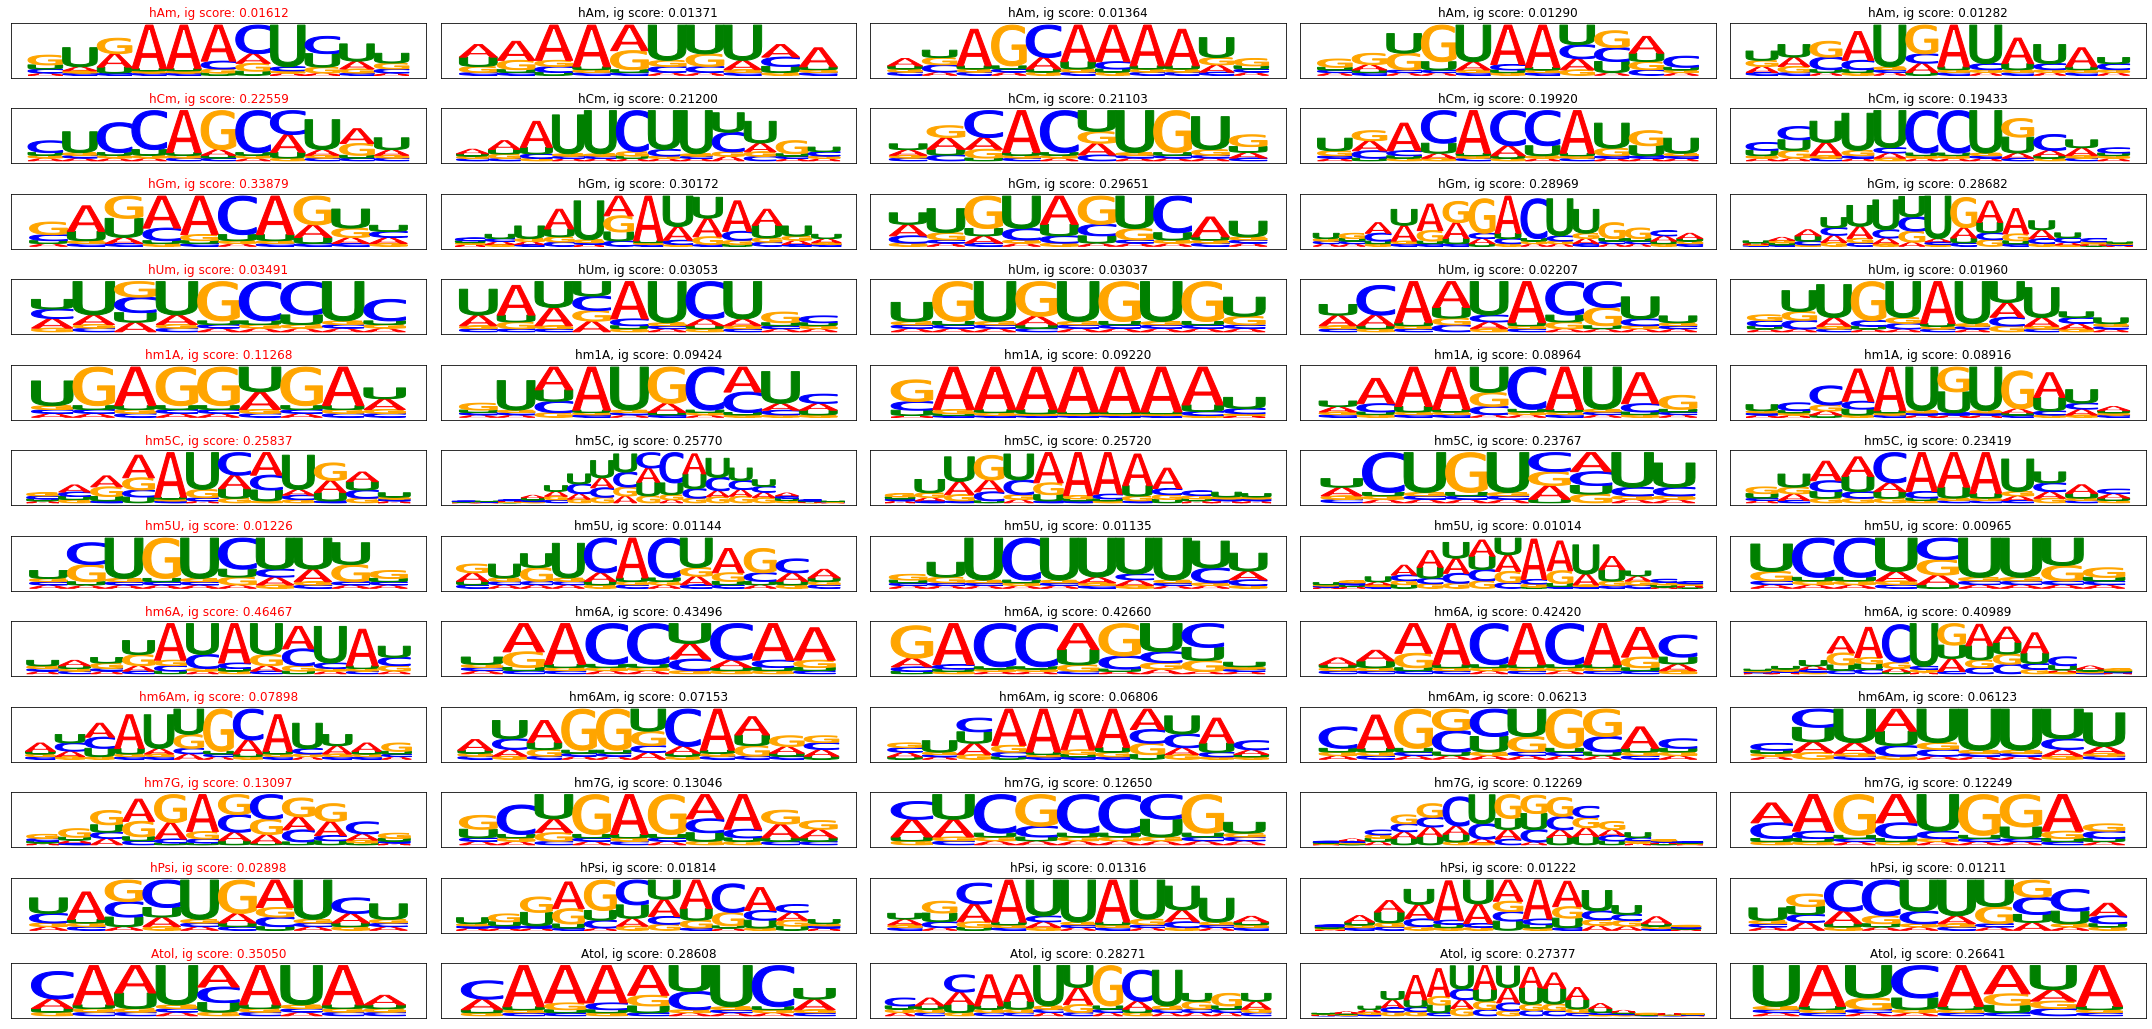

In [50]:
n_cluster = 5
ig, axes = plt.subplots(12,n_cluster,figsize=(6*n_cluster,1.2*12))



for i in range(len(RMs)):
    RM = RMs[i]
    heights = cm[RM][:]
    score = cm['%s_ig'%(RM)][:]
    score_max = np.max(score)
    for j in range(n_cluster):
        color = 'k'
        if score[j] == score_max:
            color = 'r'
        cur_ax = axes[i,j]
        cur_ax.set_title('%s, ig score: %.5f'%(RM,score[j]),color=color)
        
        # trim weights
        letter_heights = trim(heights[j,:].T)
        seqlogo(letter_heights=letter_heights,vocab='RNA',ax=cur_ax)
plt.tight_layout() 
plt.savefig('./Figs/cm.pdf')

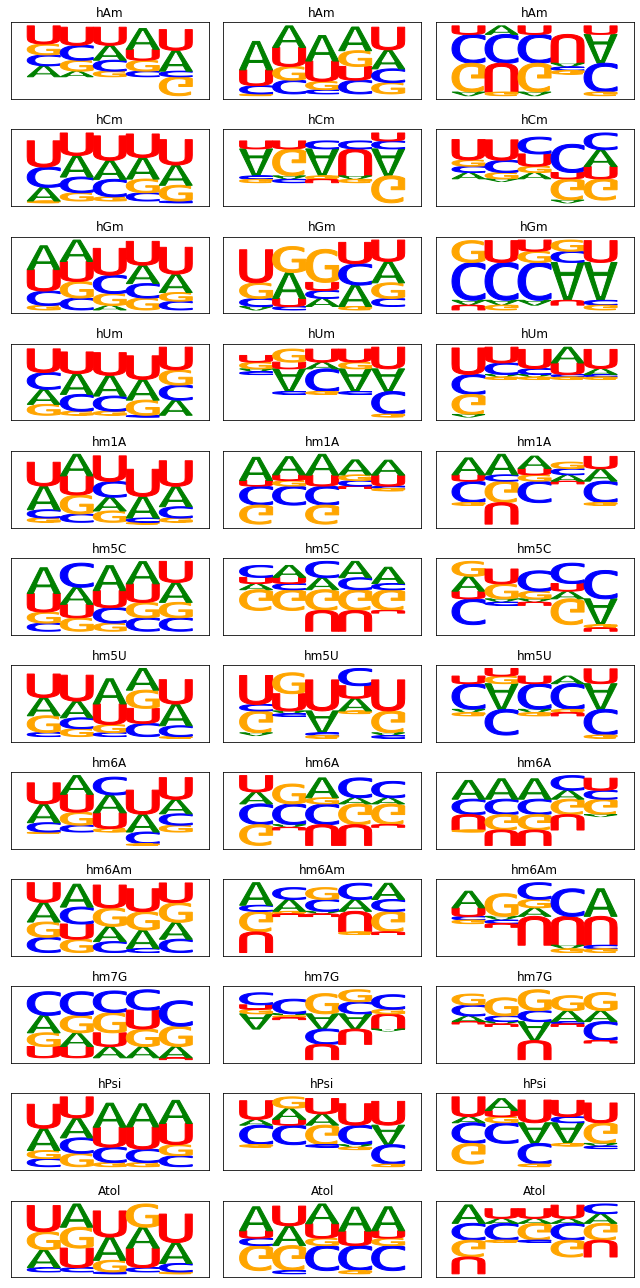

In [6]:
cm = h5py.File('./Seqs/cm_valid_51.h5','r')
ig, axes = plt.subplots(12,3,figsize=(9,1.5*12))



for i in range(len(RMs)):
    RM = RMs[i]
    heights = cm[RM][:]
    for j in range(3):
        cur_ax = axes[i,j]
        cur_ax.set_title(RM)
        seqlogo(letter_heights=heights[j,:].T,vocab='RNA',ax=cur_ax)
plt.tight_layout()
plt.savefig('./Figs/cm.png')

In [8]:
scores = h5py.File('./Seqs/cm_score_valid_51_3.h5','r')

# Visualize IG attribution Map

In [3]:
import h5py

In [4]:
attribution = h5py.File('./Seqs/ig_test_51_top5.h5','r')
attribution_withoutcut = h5py.File('./Seqs/ig_test_51_top5_withoutcut.h5','r')

In [5]:
RMs = ['hAm','hCm','hGm','hUm','hm1A','hm5C','hm5U','hm6A','hm6Am','hm7G','hPsi','Atol']

In [14]:
attribution['hAm'][:].shape

(5, 4, 51)

In [6]:
length = 51
mid = length // 2
new_dict = {name:np.zeros((5,4,9)) for name in RMs}
for RM in RMs:
    ori = attribution[RM][:][:,:,mid-4:mid+5]
#    new_dict[RM] = np.interp(ori,(ori.min(),ori.max()),(0,1))
    new_dict[RM] = ori
    if RM in ['hAm','hCm','hGm','hUm','hm1A','hm5C','hm5U','hm7G','hPsi','Atol']:
        new_dict[RM][:,:,4] = 0
    elif RM in ['hm6Am']:
        new_dict[RM][:,:,3:5] = 0
    elif RM in ['hm6A']:
        new_dict[RM][:,:,4:6] = 0

# Cut middle site

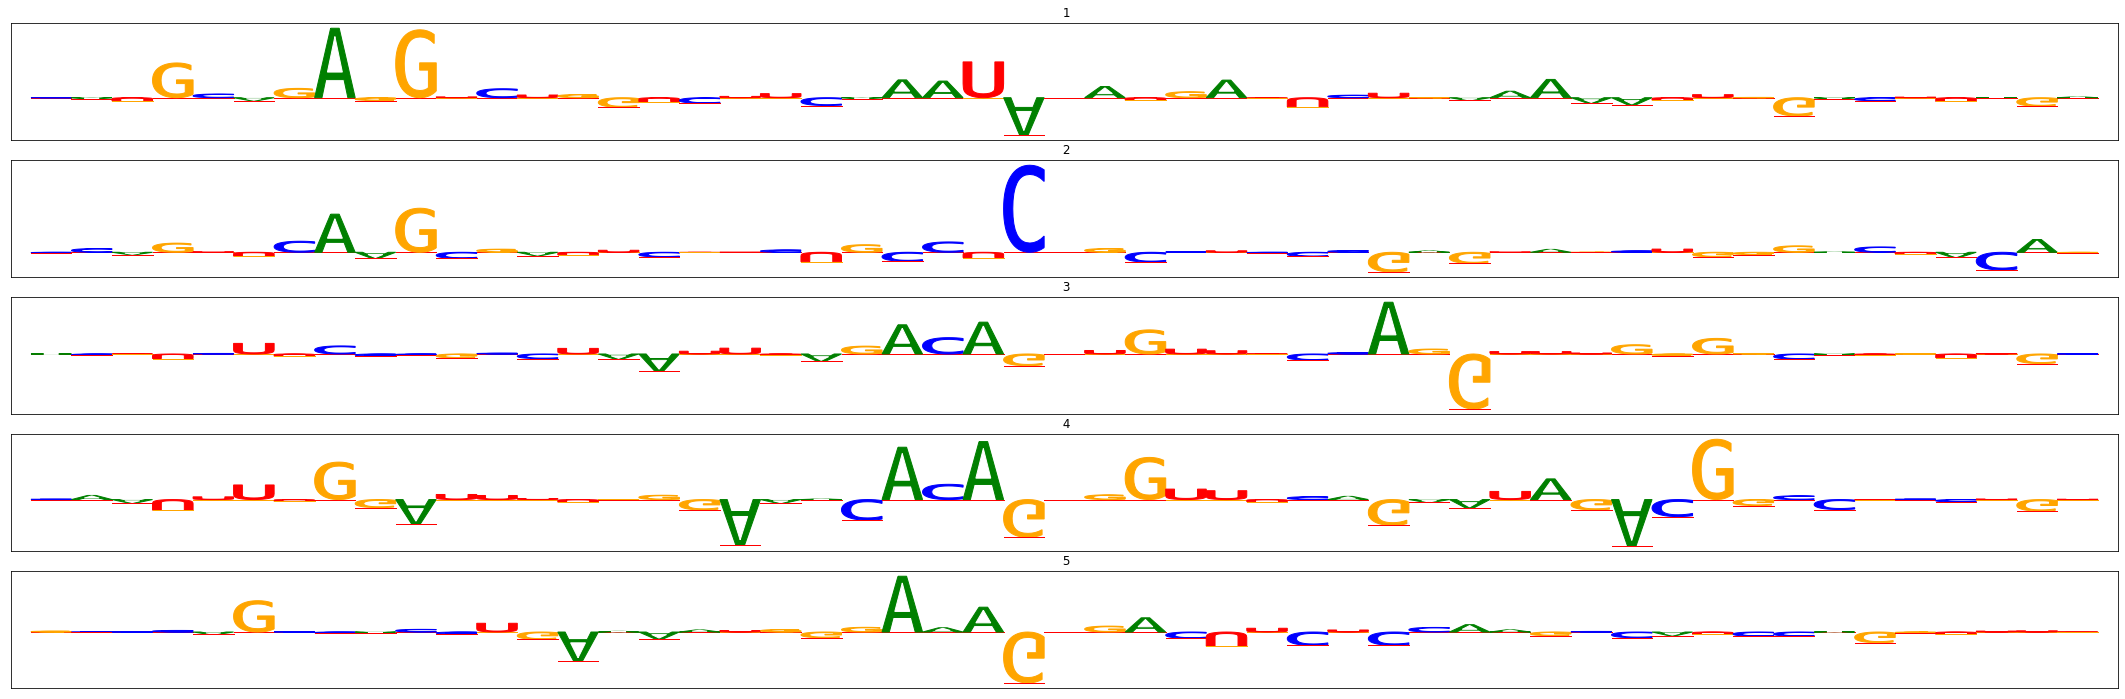

In [31]:
fig = seqlogo_fig(np.transpose(attribution['hAm'][:],axes=(2,1,0)), vocab="RNA", figsize=(30, 10), ncol=1, plot_name='')

# Without cutting

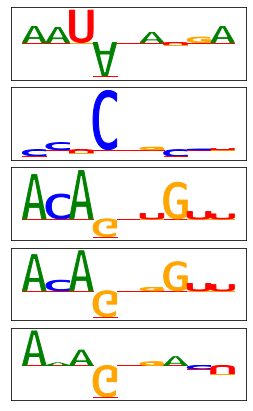

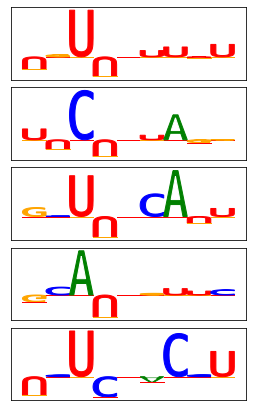

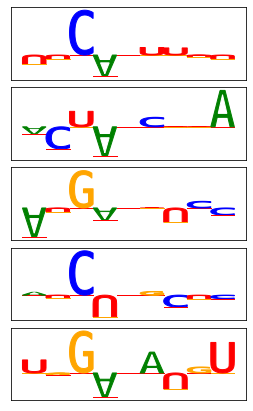

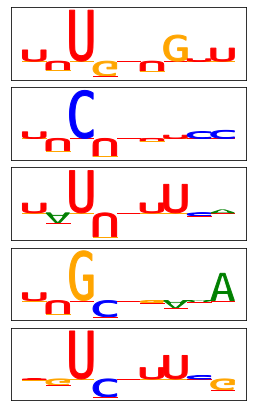

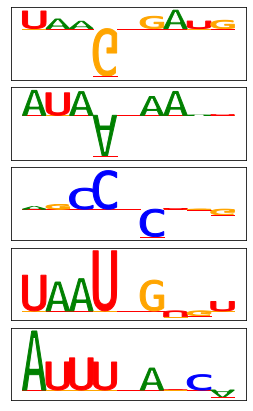

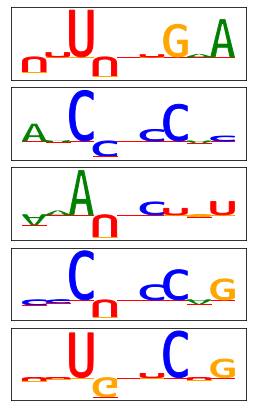

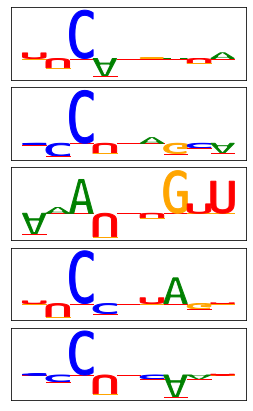

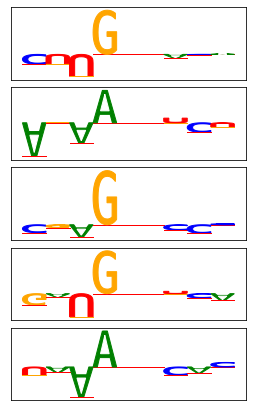

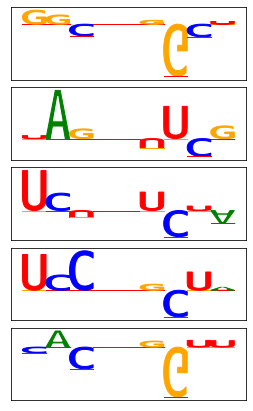

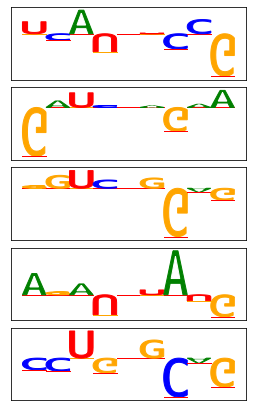

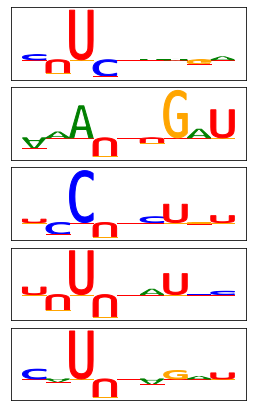

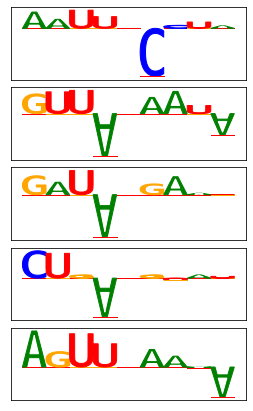

In [7]:
for RM in RMs:    
    fig = seqlogo_fig(np.transpose(new_dict[RM],axes=(2,1,0)), vocab="RNA", figsize=(4, 6), ncol=1, plot_name='')
    fig.savefig('./Figs/%s.pdf'%(RM))